In [187]:
import shap
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import copy

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.naming import *
from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_tutorial import heatmap
from util.util_pickle import load_data, save_data, get_shap_configs, load_shaps

# pan kessel
from explanations_can_be_manipulated.src.nn.enums import ExplainingMethod, LRPRule
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet
from explanations_can_be_manipulated.src.nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

device = 'cpu'
method = ExplainingMethod.lrp

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load data and pretrained models
data, target = first_mnist_batch(batch_size=100)
background, background_target = first_mnist_batch(batch_size=100, test=False)

background = background.reshape((-1, 1, 28, 28))
test_images = data[:3].reshape((-1, 1, 28, 28))

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

In [3]:
data.shape

torch.Size([100, 784])

## Load precomputed shapley values

In [172]:
shap_configs = get_shap_configs('d3')
shap_configs

100%|███████████████████████████████████| 1695/1695 [00:00<00:00, 783312.61it/s]


array(['shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0',
       'shap__background_size-400__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0'],
      dtype='<U77')

In [184]:
shaps_per_config = { config: load_shaps('d3', config) for config in shap_configs }
    
for config, data in (shaps_per_config.items()):
    print(config, data.shape)

100%|██████████████████████████████████████| 1695/1695 [00:03<00:00, 446.97it/s]


shap__background_size-100__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0 (8400, 10, 1, 28, 28)
shap__background_size-400__batch_size-10__model-cb1-8-8-8_cb2-16-16-16_seed-0 (8400, 10, 1, 28, 28)


In [173]:
shaps = load_shaps('d3', shap_configs[0])
shaps.shape

100%|██████████████████████████████████████| 1695/1695 [00:03<00:00, 466.58it/s]


(8400, 10, 1, 28, 28)

In [183]:
test_loader_shap = data_loaders(shapley_values_for=('d3', shap_configs[0]))

100%|██████████████████████████████████████| 1695/1695 [00:03<00:00, 432.52it/s]


## Import the Explainable model of Pan

In [4]:
model = ExplainableNet(model_d3).eval().to(device)

In [5]:
gamma = 2
model.change_lrp_rules(gamma=gamma, lrp_rule_nl=LRPRule.gamma)

In [5]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 0.0 LRPRule.z_b
1 0.0 LRPRule.alpha_beta
2 0.0 LRPRule.alpha_beta
3 MaxPool
4 0.0 LRPRule.alpha_beta
5 0.0 LRPRule.alpha_beta
6 0.0 LRPRule.alpha_beta
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [48]:
x = data[:1].reshape((-1,1,28,28))
expl, output, classification = get_expl(model, test_images, method)

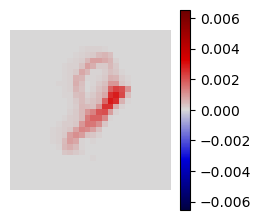

In [49]:
heatmap(expl[0].detach().reshape((28,28)), 2, 2, colorbar=True)

### Check equivalence to my implementation

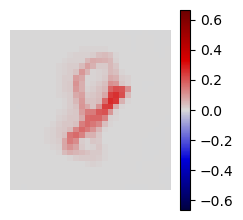

In [50]:
heatmap(rel(95)[0][0].reshape((28,28)), 2, 2, colorbar=True)

In [51]:
a = rel(95)[0][0, 0]
b = expl[0]

a.shape, b.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

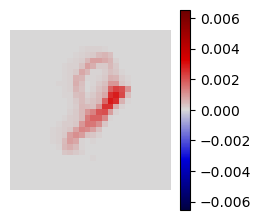

In [52]:
c = a
c[b>0] = b[b>0]
heatmap(c.detach(), colorbar=1)

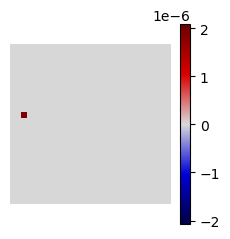

In [53]:
heatmap((a-b).detach(), colorbar=1)

In [54]:
np.abs((a-b).detach()).max()

tensor(1.9183e-06)

## SGD on Gamma

In [39]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [5]:
model = ExplainableNet(model_d3).eval().to(device)

for i, l in enumerate(model.layers): print(i, str(l).split('(')[0])

0 Convolutional
1 Convolutional
2 Convolutional
3 MaxPool
4 Convolutional
5 Convolutional
6 Convolutional
7 MaxPool
8 Flatten
9 Dense


In [86]:
for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])

0 tensor([nan], requires_grad=True) LRPRule.z_b
1 tensor([nan], requires_grad=True) LRPRule.gamma
2 tensor([nan], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([nan], requires_grad=True) LRPRule.gamma
5 tensor([nan], requires_grad=True) LRPRule.gamma
6 tensor([nan], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [102]:
config = {
    'background_size': 100,
    'batch_size': 10,
    'model': d3_tag
}
config = sorted(config)
for k in config: print( k)

background_size
batch_size
model


In [88]:
shap_predicted_class = first_batch_shap[np.arange(batch_size), classification]

In [95]:
((shap_predicted_class > 0) == (expl[:, None].detach().numpy() > 0)).sum()

39174

In [97]:
for i in range(10):
    print(((first_batch_shap[:, i] > 0) == (expl[:, None].detach().numpy() > 0)).sum())

30754
24599
27062
28275
25174
27005
29087
26487
29422
28218


In [92]:
((first_batch_shap[:, 0] - expl[:, None].detach().numpy())**2).sum()

103.42580067424151

In [147]:
combined = np.stack((shap_predicted_class[:, 0], expl.detach().numpy())).transpose((1, 0, 2, 3))
combined.shape

ValueError: all input arrays must have the same shape

In [79]:
combined = np.stack((x[:, 0].detach().numpy(), expl.detach().numpy())).transpose((1, 0, 2, 3))
combined.shape

(100, 2, 28, 28)

In [105]:
shap_predicted_class.shape, expl.shape

((100, 1, 28, 28), torch.Size([100, 28, 28]))

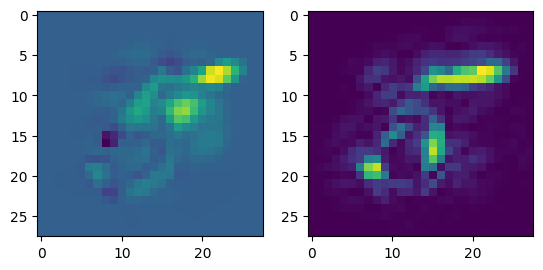

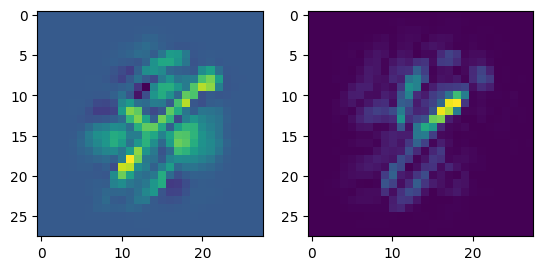

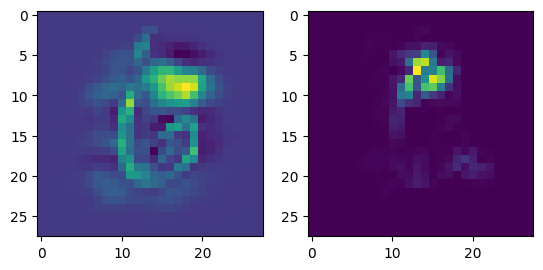

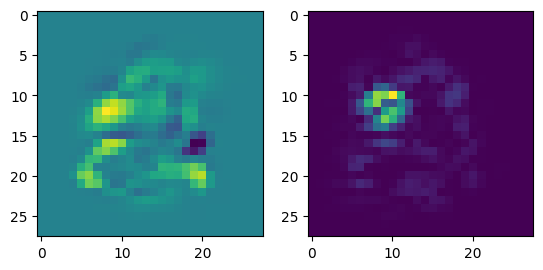

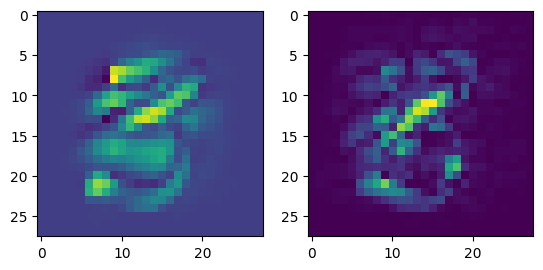

In [148]:
comb = combined.copy()

# shapeley values and lrp explanation have very differetn scales -> norm them

if True: # norm by std
    comb /= combined.std(axis=(2,3), keepdims=True)
else:    # norm by l1 norm
    comb /= np.sum(np.abs(comb), axis=(2,3), keepdims=True)
    
for shap_img, expl_img in comb[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(shap_img)
    ax2.imshow(expl_img)
    plt.show()


In [ ]:
del ExplainableNet
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [112]:
del tqdm
from tqdm import tqdm
_, test_loader = data_loaders()

In [121]:
first_batch_x, _ = first_mnist_batch()
first_batch_x.shape

torch.Size([100, 784])

In [149]:
gamma_early = torch.Tensor([0.051]).requires_grad_(True)
gamma_late  = torch.Tensor([0.050]).requires_grad_(True)

model = ExplainableNet(model_d3).eval().to(device)
model.change_lrp_rules(gamma=gamma_early, lrp_rule_nl=LRPRule.gamma, start_l=0, end_l=3)
model.change_lrp_rules(gamma=gamma_late , lrp_rule_nl=LRPRule.gamma, start_l=4, end_l=8)

for i, l in enumerate(model.layers):
    try: print(i, l.gamma, l.lrp_rule)
    except: print(i, str(l).split('(')[0])
    
gammas = []
losses = []
optimizer = torch.optim.Adam([gamma_early, gamma_late], lr=0.01)

0 tensor([0.0510], requires_grad=True) LRPRule.z_b
1 tensor([0.0510], requires_grad=True) LRPRule.gamma
2 tensor([0.0510], requires_grad=True) LRPRule.gamma
3 MaxPool
4 tensor([0.0500], requires_grad=True) LRPRule.gamma
5 tensor([0.0500], requires_grad=True) LRPRule.gamma
6 tensor([0.0500], requires_grad=True) LRPRule.gamma
7 MaxPool
8 Flatten
9 0.0 LRPRule.alpha_beta


In [ ]:
n_epochs = 1000
loss_func = 'shap prediction_only'

def proj(gamma):
    with torch.no_grad():
        if gamma.data < 0: gamma.zero_()

for i in tqdm(range(n_epochs)):
    for x, target in (test_loader):
        x = first_batch_x # REMOVE AGAIN
        batch_size = len(x)
        x = x.reshape((batch_size, 1, 28, 28)).data

        optimizer.zero_grad()

        # calculate entropy loss
        expl, output, classification = get_expl(model, x, method)

        # construct 'probability distribution'
        if loss_func=='entropy':
            print(expl.view(-1)[:10])
            dist = expl.abs()
            dist /= dist.sum((1,2), keepdim=True)
            ent = torch.special.entr(dist)
            print(ent)
            loss = ent.sum()
            
        elif loss_func=='shap prediction_only':
            shap_predicted_class = first_batch_shap[np.arange(batch_size), classification][:, 0]
            shap_predicted_class = torch.Tensor(shap_predicted_class)
            loss = ((shap_predicted_class - expl)**2).sum()
            
        # update gammas
        loss.backward()
        optimizer.step()
        # project into valid range
        proj(gamma_early)
        proj(gamma_late)
        
        a, b = float(gamma_early.detach()), float(gamma_late.detach())
        gammas.append([a, b])
        losses.append(loss.data)
        
        # print('loss: ', float(loss.data))
        # print('early:', a, float(model.layers[1].gamma.data), float(model.layers[1].gamma.grad))
        # print('late: ', b, float(model.layers[4].gamma.data), float(model.layers[4].gamma.grad))
        
        if 'shap' in loss_func: # REMOVE AGAIN
            break # shap vals only available for first batch for now

 75%|██████████████████████████████          | 751/1000 [03:49<01:15,  3.29it/s]

#### minimize MSE to shapley values (first batch only)

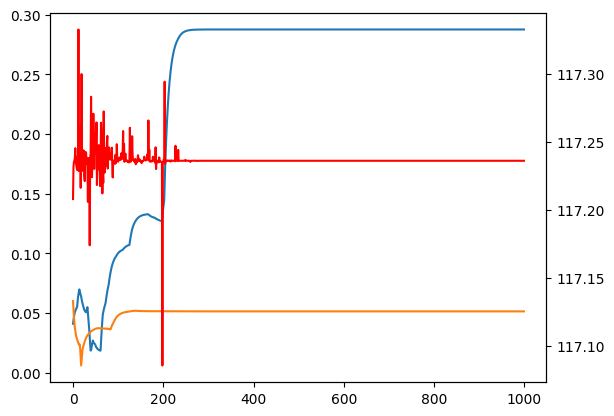

In [189]:
tag = 'results__SGD_shap__batch1__MSE_v1'
# save_data('d3', tag, (gammas, losses))

gs, ls = load_data('d3', tag)

fig, ax = plt.subplots()
ax.plot(gs)
ax.twinx().plot(ls, c='r')

In [159]:
a, b = float(gamma_early.detach().numpy()), float(gamma_late.detach().numpy())
a, b

(0.2876599133014679, 0.05137185752391815)

#### minimize expl L1 norm

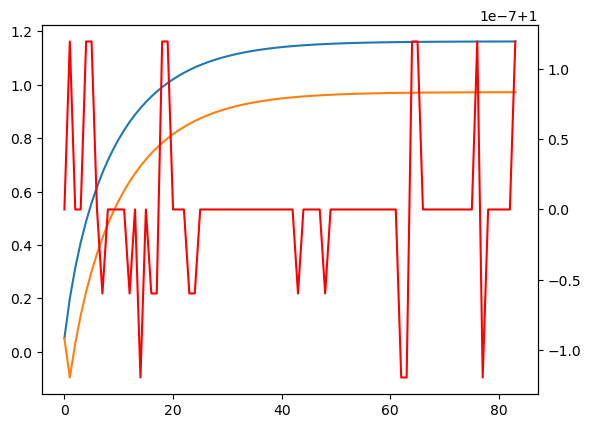

In [60]:
fig, ax = plt.subplots()
ax.plot(gammas)
ax.twinx().plot(losses, c='r')

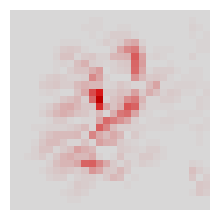

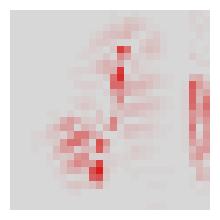

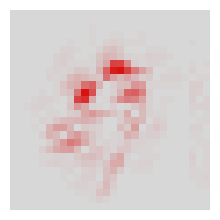

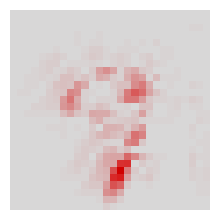

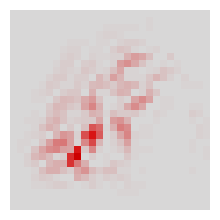

In [101]:
for ex in expl[:5]:
    heatmap(ex.detach())
    plt.show()

## Precompute Shap values

In [11]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

In [24]:
del tqdm
from tqdm import tqdm
_, test_loader = data_loaders(batch_size=10)

In [25]:
e = shap.DeepExplainer(model_d3, background)

In [82]:
shap_per_batch = []
# X = x
for x in tqdm(X):
    x = x.reshape((-1,1,28,28)).data
    with HiddenPrints():
        vals = e.shap_values(x)                           # dimensions: [num_classes, [datapoints, channels, x, y]]
        vals = np.stack(vals).transpose((1, 0, 2, 3, 4))  # dimensions: [datapoints, num_classes, channels, x, y]
        shap_per_batch.append(vals)

100%|█████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


In [84]:
np.stack(shap_per_batch).reshape((100, 10, 1, 28, 28)).shape

(100, 10, 1, 28, 28)

In [85]:
first_batch_shap = np.stack(shap_per_batch).reshape((100, 10, 1, 28, 28))
first_batch_shap.shape

(100, 10, 1, 28, 28)

In [83]:
# first_batch_shap_old = first_batch_shap

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

## LRP computation (my implementation)

In [14]:
relevancies_per_mode = {}

In [15]:
modes = {
    0: "LRP-0.", 
    1: "Gamma. l<4 gamma=0.125",
    2: "Gamma. l<4 gamma=0.25",
    3: "Gamma. l<4 gamma=0.5",
    
    92: "Gamma. l<1000 gamma=0.25",
    95: "Gamma. l<1000 gamma=2.",
    99: "Gamma. l<1000 gamma=inf",
   
    # 99: "info."
}

In [16]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [17]:
A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

In [18]:
for mode in tqdm(modes.values()):
    if mode in relevancies_per_mode: continue
    rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
    if mode!="info": relevancies_per_mode[mode] = rels

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
lrp_numpy = rel(92)[0][:3].numpy()
lrp_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in lrp_numpy[None]]

print(np.array(lrp_numpy).shape)

(1, 3, 28, 28, 1)


In [22]:
lrp_numpy[0].shape

(3, 28, 28, 1)

In [27]:
np.array(shap_numpy).shape, np.array(lrp_numpy).shape, test_numpy.shape

NameError: name 'shap_numpy' is not defined

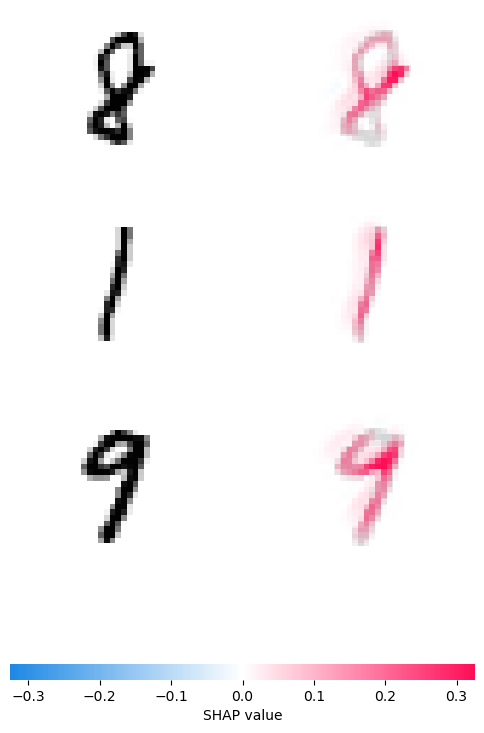

In [30]:
# plot the feature attributions
shap.image_plot(lrp_numpy, -test_numpy)